<a href="https://colab.research.google.com/github/amandugar/auto-mobiles/blob/main/automobiles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch-lr-finder
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
if(os.path.isdir('/content/final-dataset-automobiles/')):
  print ('exist')
else:
  !cp '/content/drive/MyDrive/final-dataset-automobiles.zip' '/content'


In [4]:
if(os.path.isdir('/content/final-dataset-automobiles/')):
  print('exist')
else:
  !unzip final-dataset-automobiles.zip

Streaming output truncated to the last 5000 lines.
  inflating: final-dataset-automobiles/2nd Row Left Side Seat Armrest/IMG-20210609-WA0113-resized.jpg  
  inflating: final-dataset-automobiles/2nd Row Left Side Seat Armrest/IMG-20210609-WA0114-resized.jpg  
  inflating: final-dataset-automobiles/2nd Row Left Side Seat Armrest/IMG-20210609-WA0115-resized.jpg  
  inflating: final-dataset-automobiles/2nd Row Left Side Seat Armrest/IMG-20210609-WA0116-resized.jpg  
  inflating: final-dataset-automobiles/2nd Row Left Side Seat Armrest/IMG-20210609-WA0117-resized.jpg  
  inflating: final-dataset-automobiles/2nd Row Left Side Seat Armrest/IMG-20210609-WA0119-resized.jpg  
  inflating: final-dataset-automobiles/2nd Row Left Side Seat Armrest/IMG-20210609-WA0134-resized.jpg  
  inflating: final-dataset-automobiles/2nd Row Left Side Seat Armrest/IMG-20210609-WA0137-resized.jpg  
  inflating: final-dataset-automobiles/2nd Row Left Side Seat Armrest/IMG-20210609-WA0138-resized.jpg  
  inflating: 

In [5]:
!rm '/content/final-dataset-automobiles.zip'

In [6]:
import numpy as np
import torch
from torch_lr_finder import LRFinder
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image, ImageDraw
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import os
import cv2
import pathlib
import torch.optim as optim

In [7]:
path = "final-dataset-automobiles"
for folder in os.listdir(path):
  for img_file in os.listdir(os.path.join(path,folder)):
    img_file = os.path.join(path,folder,img_file)
    try:
      img = Image.open(img_file)
      if img.mode!='RGB':
        os.remove(img_file)
        print(img_file)
    except:
      print(img_file)
      os.remove(img_file)

In [8]:
transform = transforms.Compose([
                                transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5],[0.5])
                              ])

In [9]:
dataset = datasets.ImageFolder('final-dataset-automobiles',transform=transform)
dataset_len = len(dataset)
dataset_len

5121

In [25]:
train_len,test_len = dataset_len - 1000,1000
train_set,test_set = torch.utils.data.random_split(dataset,[train_len,test_len],generator=torch.manual_seed(30))
batch_size = 300
train_set = DataLoader(dataset=train_set,shuffle=True,batch_size=batch_size)
test_set = DataLoader(dataset=test_set,shuffle=True,batch_size=batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using Device: ', device)

Using Device:  cuda


In [26]:
root=pathlib.Path('/content/final-dataset-automobiles')
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [27]:
classes

['2nd Row Left Side Seat Armrest',
 '2nd Row Right Side Seat Armrest',
 '2nd Row Seat Belt (L)',
 '2nd Row Seat Belt (R)',
 '2nd Row Seat Belt Buckle Right',
 'AUX - USB Socket',
 'Accelerator Pedal',
 'Accessory Socket (Centre Console)',
 'Accessory Socket (Dash Board)',
 'Accessory Socket (Inside Armrest)',
 'Accessory socket location (luggage compartment)',
 'Air Bag Light and Dashboard',
 'Air Cleaner',
 'Airbag Label',
 'Audio System',
 'Bill - Coin Holder',
 'Brake - Clutch Fluid Reservoir',
 'Brake Pedal',
 'Centre Outlet (L)',
 'Centre Outlet (R)',
 'Child-Proof Locks (Rear L)',
 'Child-Proof Locks (Rear R)',
 'Coolant Reservoir',
 'Courtesy Lights (Duplicate)',
 'Door Locks (Driver side - O)',
 'Door Locks (Front Passenger side - I)',
 'Door Locks (Front Passenger side - O)',
 'Door Locks (Rear Left)',
 'Door Locks (Rear Right)',
 'Driver Door Switch',
 'Driver Side Defroster Outlet',
 'Driver Side Outlet',
 'Driver Side Seat Belt Buckle',
 'Engine Hood Latch',
 'Engine Oil Fi

In [28]:
len(classes)

38

In [29]:
model = models.resnet18(pretrained=True)

In [30]:
for param in model.parameters(): 
  param.requires_grid = False 
  model.fc = torch.nn.Linear(in_features=512,out_features=38,bias=True) 
  model = model.to(device)

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(),lr=4.04e-04,weight_decay=10e-5)


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.04E-04


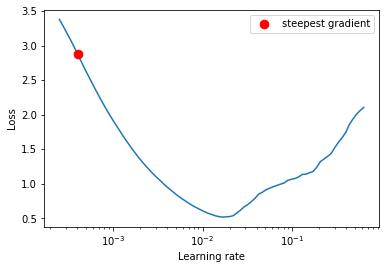

In [32]:
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_set,start_lr=10e-5, end_lr=1, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset()

In [33]:
model.train()
for epoch in range(10):
  total_correct = 0.0
  running_loss = 0.0
  for i,(inputs,labels) in enumerate(train_set):
    inputs,labels = inputs.to(device),labels.to(device)
    output = model(inputs)
    output_idx = torch.argmax(output,dim=1)
    total_correct+=(labels == output_idx).sum().item()
    optimizer.zero_grad()
    loss = criterion(output,labels)
    running_loss+= loss.item()*inputs.size(0)
    loss.backward()
    optimizer.step()
  print(f'Epoch: {epoch} Loss = {running_loss/train_len} Accuracy:{(total_correct/train_len)*100}%')

Epoch: 0 Loss = 1.455906404609444 Accuracy:70.78379034214997%
Epoch: 1 Loss = 0.23547055138904646 Accuracy:95.7534578985683%
Epoch: 2 Loss = 0.10630757241421492 Accuracy:97.11235137102645%
Epoch: 3 Loss = 0.06556731345684776 Accuracy:98.03445765590875%
Epoch: 4 Loss = 0.05082217125717919 Accuracy:98.25285124969668%
Epoch: 5 Loss = 0.04323971793652159 Accuracy:98.32564911429264%
Epoch: 6 Loss = 0.040115529784760524 Accuracy:98.34991506915797%
Epoch: 7 Loss = 0.037221301896635466 Accuracy:98.15578743023538%
Epoch: 8 Loss = 0.03525298433475516 Accuracy:98.1800533851007%
Epoch: 9 Loss = 0.034171793108150175 Accuracy:98.32564911429264%


In [34]:
with torch.no_grad():
  model.eval()
  total_loss = 0.0
  total_correct = 0.0
  for inputs,labels in test_set:
    labels = labels.to(device)
    outputs = model(inputs.to(device))
    loss = criterion(outputs,labels)
    total_loss = loss.item() * inputs.size(0)
    output_idx = torch.argmax(outputs,dim=1)
    total_correct+=sum(labels == output_idx)
print(f'Loss = {running_loss/test_len} Accuracy:{(total_correct/test_len)*100}%')

Loss = 0.14082195939868689 Accuracy:95.20000457763672%


In [35]:
torch.save(model.state_dict(),'auto.pt')

In [36]:
import numpy as np
import torch
from torchvision import models,transforms
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
labels = ['2nd Row Left Side Seat Armrest','2nd Row Right Side Seat Armrest','2nd Row Seat Belt (L)',
 '2nd Row Seat Belt (R)',
 '2nd Row Seat Belt Buckle Right',
 'AUX - USB Socket',
 'Accelerator Pedal',
 'Accessory Socket (Centre Console)',
 'Accessory Socket (Dash Board)',
 'Accessory Socket (Inside Armrest)',
 'Accessory socket location (luggage compartment)',
 'Air Bag Light and Dashboard',
 'Air Cleaner',
 'Airbag Label',
 'Audio System',
 'Bill - Coin Holder',
 'Brake - Clutch Fluid Reservoir',
 'Brake Pedal',
 'Centre Outlet (L)',
 'Centre Outlet (R)',
 'Child-Proof Locks (Rear L)',
 'Child-Proof Locks (Rear R)',
 'Coolant Reservoir',
 'Courtesy Lights (Duplicate)',
 'Door Locks (Driver side - O)',
 'Door Locks (Front Passenger side - I)',
 'Door Locks (Front Passenger side - O)',
 'Door Locks (Rear Left)',
 'Door Locks (Rear Right)',
 'Driver Door Switch',
 'Driver Side Defroster Outlet',
 'Driver Side Outlet',
 'Driver Side Seat Belt Buckle',
 'Engine Hood Latch',
 'Engine Oil Filler Cap',
 'Front Dome Light',
 'Second Row Seat Belt Buckle (Left)',
 'Sound System']
model_path = 'auto.pt'
img_file_path = '/content/final-dataset-automobiles/Door Locks (Rear Left)/20210626_123914-resized.jpg'
transform = transforms.Compose([transforms.CenterCrop(224),transforms.ToTensor()])
model = models.resnet18()
print (len(labels))
model.fc = torch.nn.Linear(in_features=512,out_features=len(labels),bias=True)
model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))
model.eval()
img = Image.open(img_file_path)
img = transform(img)
prediction = model(img.unsqueeze(0))
print(prediction)
result = torch.argmax(prediction)
print(result)
print(f'This is a {labels[result]}')

38
tensor([[-1.4158,  0.6523, -1.0774,  1.0023, -0.0994,  1.9230,  0.1631, -1.0880,
          1.9537, -0.4976, -0.1885, -0.3087, -0.3801, -1.2450,  0.0781,  0.9860,
         -0.8684, -2.0925,  0.8802, -1.5492,  0.8984, -0.3179, -0.9037, -0.3464,
         -0.1979, -0.6543, -0.7859,  5.6532,  0.5156, -0.9196, -1.5577, -0.4137,
         -1.0134, -1.1208, -0.8911,  0.1191, -0.3959, -0.7972]],
       grad_fn=<AddmmBackward>)
tensor(27)
This is a Door Locks (Rear Left)
